# Comparison with MotionLines

MotionLines can be used to represent areas by change the width of the curves proportionally to the area of objects. This solution however is not sufficient to generate a good representation of the data. In this notebook we compare the results of this adaptation of MotionLines and MoReVis.

In [1]:
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.style.use("seaborn-paper")
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Roboto'
#plt.rcParams['axes.axisbelow'] = True

import sys
import os
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.append(module_path)

from morevis import MoReVis
from rugs_family import MotionLines
from datasets import load_dataset
from utils import plot_summary

## Helper Functions

In [2]:
color_mapping = {
    "spurious": "#ff7f00",
    "missing": "#6a3d9a",
    "both": "#e31a1c"
}

color_mapping_name = {
    "Spurious": "#ff7f00",
    "Missing": "#6a3d9a",
    "Spurious + Missing": "#e31a1c"
}

In [4]:
def concat_connections(df, keep_dasheds =  True):
    """
    This function concat the connections and rectangles of individual objects to obtain
    higher visualization quality (remove crips edges between rectangles).

    Inputs:
        df: Dataframe with the rectangles result of MoReVis or MotionLines
        keep_dasheds: Boolean to keep the dashed connections or joint them with the rest of the curve

    Outputs:
        df: Dataframe with the connected rectangles in the column "shape"
    """
    object_list = df.object.unique()
    object_list.sort()
    update_result = {"object": [],"shape": [], "color": [], "style": []}

    for object_ in object_list:
        df_object = df[df.object == object_]
        df_object = df_object.sort_values(by="timestep")
        shape = []

        if not keep_dasheds:
            df_object_dashed = df_object[df_object["style"] == "dashed"]
            if len(df_object_dashed) > 0:
                for _, row in df_object_dashed.iterrows():
                    update_result["object"].append(object_)
                    update_result["shape"].append(row["shape"])
                    update_result["color"].append(row.color)
                    update_result["style"].append("dashed")
                    
            df_object = df_object[df_object["style"] != "dashed"]

        for _, row in df_object.iterrows():
            shape.append(Polygon(row["shape"]))
        shape = unary_union(shape)

        if shape.geom_type == "MultiPolygon":
            for s in shape.geoms:
                update_result["object"].append(object_)
                update_result["shape"].append(list(zip(*s.exterior.xy)))
                update_result["color"].append(row.color)
                update_result["style"].append("solid")
        else:
            update_result["object"].append(object_)
            update_result["shape"].append(list(zip(*shape.exterior.xy)))
            update_result["color"].append(row.color)
            update_result["style"].append("solid")

    update_result = pd.DataFrame(update_result)
    tmin = df.timestep.min()
    tmax = df.timestep.max()
    # little trick to keep the plot correct
    update_result["timestep"] = tmin
    update_result.loc[0, "timestep"] = tmax
    return update_result

def verify_intersections_rect(df_):
    """
    Verify which of the rectangles have spurious and missing intersections.
    
    Inputs:
        df_: Dataframe with the rectangles result of MoReVis or MotionLines

    Outputs:
        results: Dataframe with the results of the verification
    """
    df = df_[df_["shape_type"] == "rect"]

    results = {
        "timestep": [],
        "object1": [],
        "object2": [],
        "intersection_1d": [],
        "intersection_2d": [],
        "spurious_intersection": [],
        "missing_intersection": [],
    }

    timesteps = df.timestep.unique().tolist()
    timesteps.sort()

    for t in timesteps:
        df_t = df[df.timestep == t]
        objects_list = df_t.object.unique().tolist()
        objects_list.sort()
        rectangles = df_t["shape"].values
        regions = df_t["points"].values

        for i in range(len(objects_list)):
            for j in range(i+1, len(objects_list)):
                rectangle_i = Polygon(rectangles[i]).convex_hull
                rectangle_j = Polygon(rectangles[j]).convex_hull
                I = rectangle_i.intersection(rectangle_j).area

                region_i = Polygon(regions[i]).convex_hull
                region_j = Polygon(regions[j]).convex_hull
                W  = region_i.intersection(region_j).area

                results["timestep"].append(t)
                results["object1"].append(objects_list[i])
                results["object2"].append(objects_list[j])
                results["intersection_1d"].append(I > 0)
                results["intersection_2d"].append(W > 0)
                results["spurious_intersection"].append(I > 0 and W == 0)
                results["missing_intersection"].append(I == 0 and W > 0)

    results = pd.DataFrame(results)
    return results

def plot_wrong_objects(result, ax, line_width = 2, metric_font_size = 12, plot_metrics = True):
    """
    Plot the rectangles with spurious or missing intersections.

    Inputs:
        result - DataFrame result of MoReVis or MotionLines
        ax - Matplotlib axis
        line_width - Line width of the curves
        metric_font_size - Font size of the metrics
        plot_metrics - Boolean to plot the metrics
    """

    metric = verify_intersections_rect(result)

    updated_result = result.copy()
    updated_result["color"] = "#377eb8"
    
    update_result_curves = concat_connections(updated_result)
    update_result_curves["line_width"] = line_width
    update_result_curves["ec_color"] = "#30303080"
    update_result_curves["color"] = "#377eb825"
    
    updated_result["keep"] = False
    
    for _, row in metric.iterrows():
        timestep, object1, object2 = row.timestep, row.object1, row.object2

        if row["spurious_intersection"] or row["missing_intersection"]:
            b = ((updated_result.timestep - timestep).abs() <= 0.5) & ((updated_result.object == object1) | (updated_result.object == object2))
            cur_color = updated_result.loc[b, "color"].values[0]
            
        if row["spurious_intersection"]:
            if cur_color == "#6a3d9a" or cur_color == "#e31a1c":
                updated_result.loc[b, "color"] = "#e31a1c"
            else:
                updated_result.loc[b, "color"] = "#ff7f00"
            updated_result.loc[b,"style"] = "solid"
            updated_result.loc[b,"keep"] = True

        elif row["missing_intersection"]:
            if cur_color == "#ff7f00" or cur_color == "#e31a1c":
                updated_result.loc[b, "color"] = "#e31a1c"
            else:
                updated_result.loc[b, "color"] = "#6a3d9a"

            updated_result.loc[b,"style"] = "solid"
            updated_result.loc[b,"keep"] = True

    updated_result = updated_result[updated_result.keep]
    updated_result = concat_connections(updated_result)
    updated_result["ec_color"] = "#10101000"
    plot_summary(updated_result, ax)
    plot_summary(update_result_curves, ax = ax)

    
    
    if plot_metrics:
        spurious_intersections = metric.loc[metric.intersection_1d, "spurious_intersection"].mean()
        missing_intersections = metric.loc[metric.intersection_2d, "missing_intersection"].mean()

        ax.annotate(
            f"Spurious: {int(100*spurious_intersections)}%", 
            (0.02, -0.11), 
            xycoords="axes fraction", 
            fontsize=metric_font_size
        )
        ax.annotate(
            f"Missing: {int(100*missing_intersections)}%", 
            (0.2, -0.11), 
            xycoords="axes fraction", 
            fontsize=metric_font_size
        )

    ax.set_xlim(result.timestep.min(), result.timestep.max())

## Is MotionLines enough?

A method to represent areas with MotionLines: use the height of the curves proportional to the area value. 
It is possible to select a proportion scale factor to create these heights. We can variate this scaling factor to obtain thiner of larger curvers and evaluate the metrics according to this scale factor.

In [5]:
wildtrack_df = load_dataset("wildtrack_use_case")

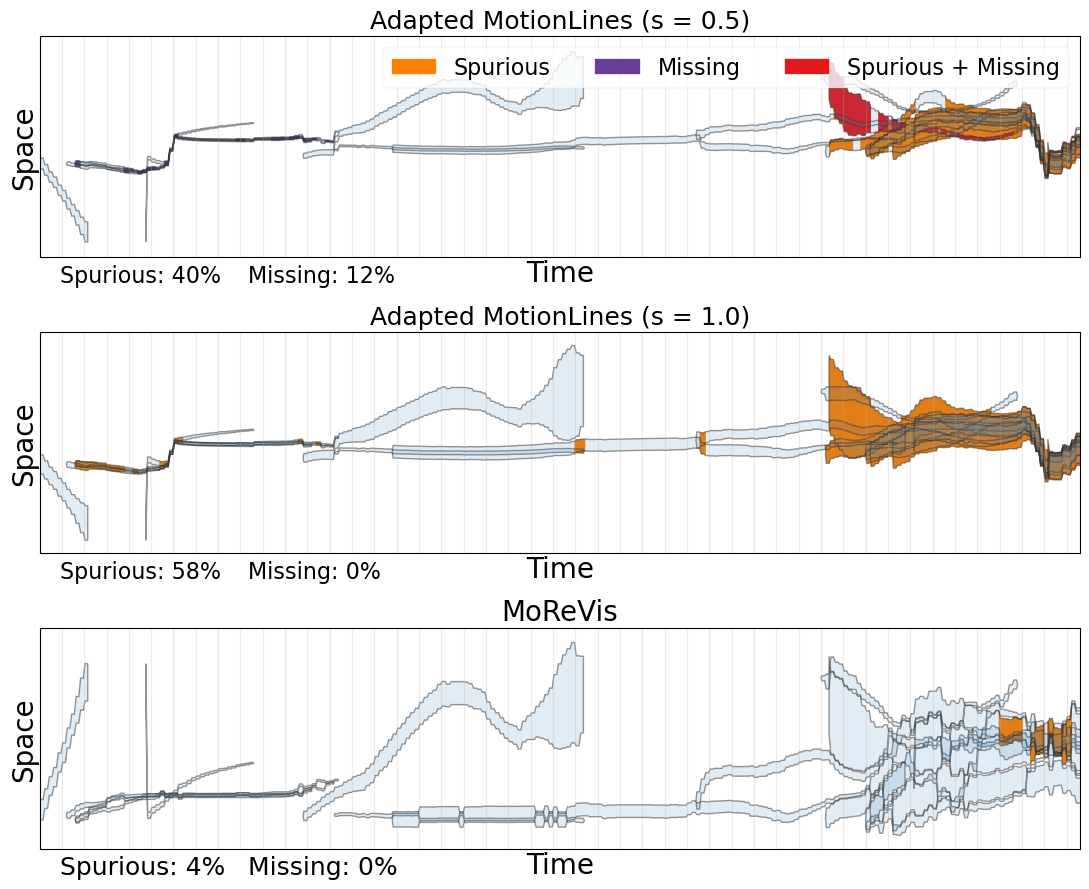

In [7]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (11, 9))

factors = [0.5, 1.0]
for i, factor in enumerate(factors):
    result = MotionLines(
        wildtrack_df,
        proportional_height = True,
        height_method = f"area_max_{factor}",
        plot = False,
    )
    
    plot_wrong_objects(result, axs[i], line_width =  1, metric_font_size = 16)
    axs[i].set_title(f"Adapted MotionLines (s = {factor})", fontsize=18)

result = MoReVis(wildtrack_df, plot = False)
plot_wrong_objects(result, axs[2], line_width = 1, metric_font_size = 18)
axs[2].set_title(f"MoReVis", fontsize=20)

handles = [mpatches.Patch(color=value, label=key) for (key, value) in color_mapping_name.items()]
axs[0].legend(handles=handles, loc="upper right", fontsize=16, ncol = 3)

plt.tight_layout()
plt.savefig("plots/motionlines_comparison.svg", format = "svg", dpi = fig.dpi)
plt.show()

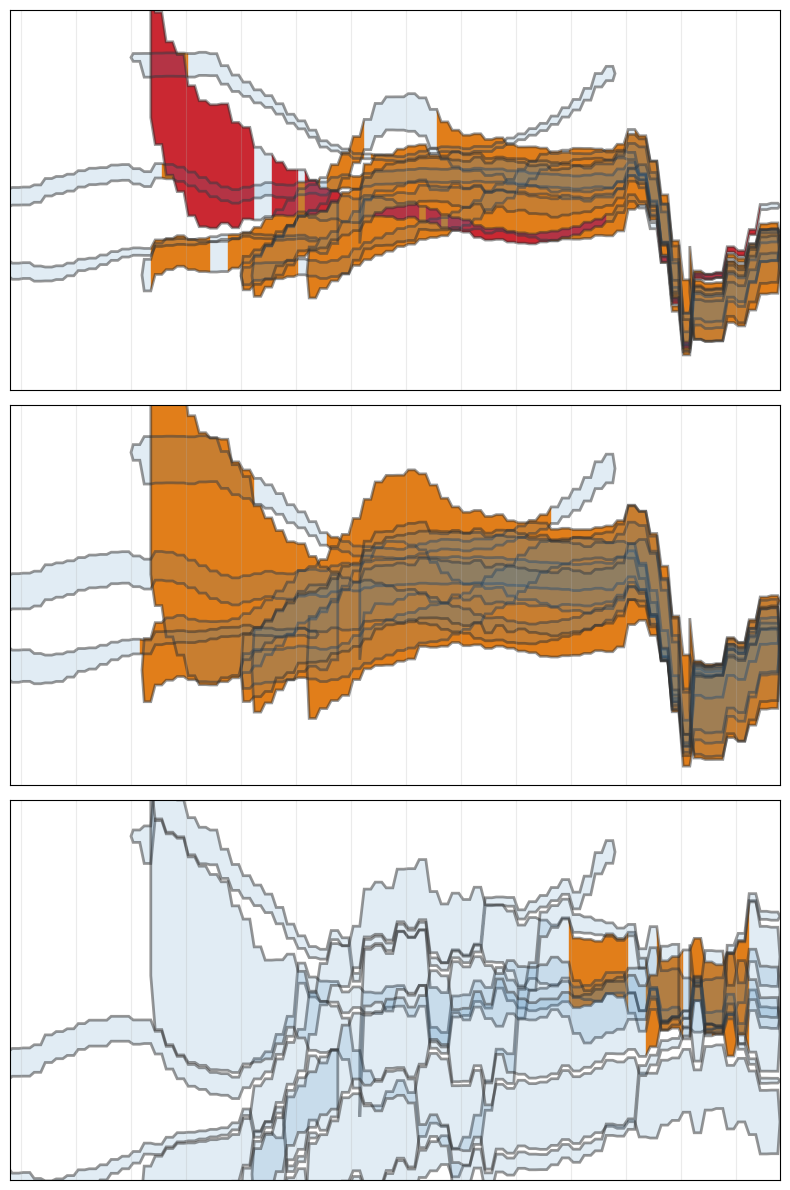

In [8]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 12))

factors = [0.5, 1]
for i, factor in enumerate(factors):
    result = MotionLines(
        wildtrack_df,
        proportional_height = True,
        height_method = f"area_max_{factor}",
        plot = False,
    )
    plot_wrong_objects(result, axs[i], plot_metrics=False, line_width = 2)

result = MoReVis(wildtrack_df, plot = False)
plot_wrong_objects(result, axs[2], plot_metrics=False, line_width = 2)

for i in range(3):
    axs[i].set_xlim(330, 400)
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_title("")

axs[0].set_ylim(0.27, 1.1)
axs[1].set_ylim(0.27, 1.1)
axs[2].set_ylim(0.05, 1.1)

plt.tight_layout()
plt.savefig("plots/motionlines_comparison_zoom.svg", format = "svg", dpi = fig.dpi)
plt.show()

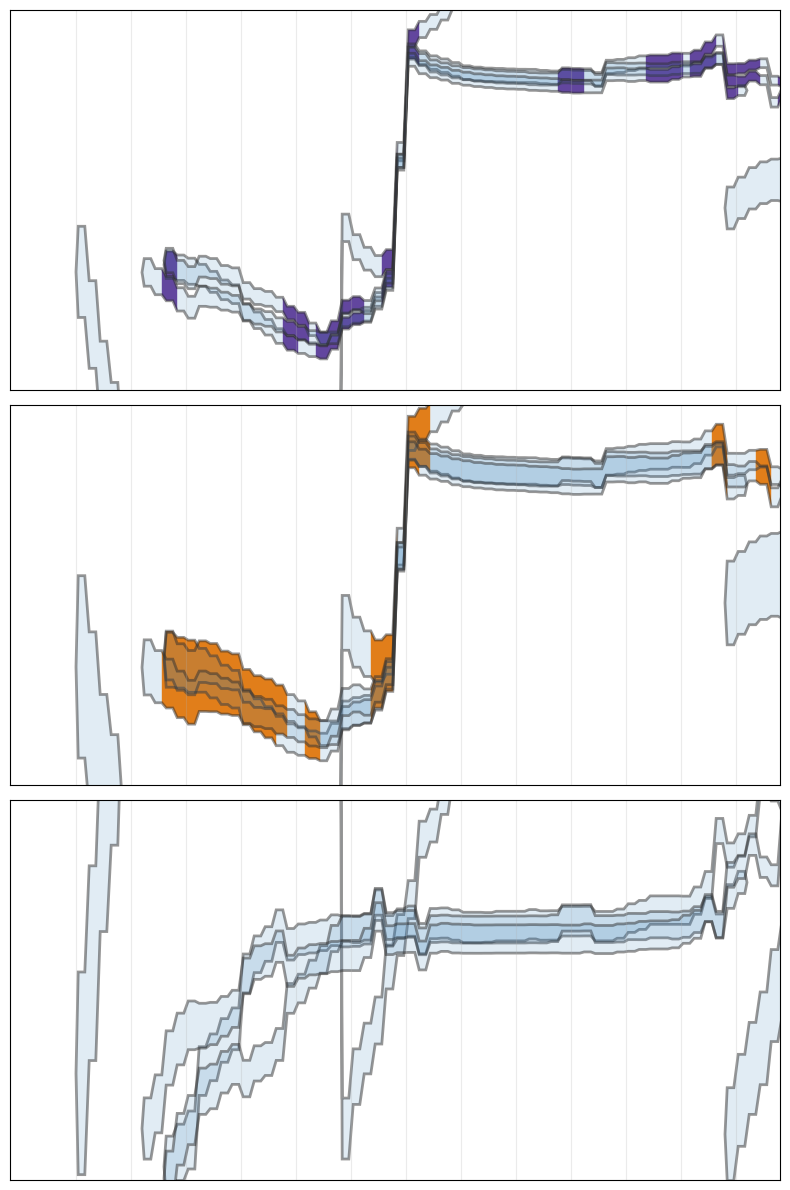

In [9]:
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 12))

factors = [0.5, 1]
for i, factor in enumerate(factors):
    result = MotionLines(
        wildtrack_df,
        proportional_height = True,
        height_method = f"area_max_{factor}",
        plot = False,
    )
    plot_wrong_objects(result, axs[i], plot_metrics=False, line_width = 2)

result = MoReVis(wildtrack_df, plot = False)
plot_wrong_objects(result, axs[2], plot_metrics=False, line_width = 2)

for i in range(3):
    axs[i].set_xlim(160, 230)
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_title("")

axs[0].set_ylim(0.35, 0.65)
axs[1].set_ylim(0.35, 0.65)
axs[2].set_ylim(0, 0.27)

plt.tight_layout()
plt.savefig("plots/motionlines_comparison_zoom_start.svg", format = "svg", dpi = fig.dpi)
plt.show()

## Adapted MotionLines with varying widths

We can use the method of area representation to represent area with an adapted version of MotionLines. However, to verify the impact of the scale of the widths on the missing and spurious intersections, we variate this scalar factor. With more thin curves, it is expected to have more missing intersections, and with larger intersections more spurious intersections will appear.

In [8]:
motivating_df = load_dataset("motivating")
wildtrack_df = load_dataset("wildtrack_use_case")
hurdat_df = load_dataset("hurdat_use_case")

In [9]:
factors = [0.25, 0.5, 0.75, 1]

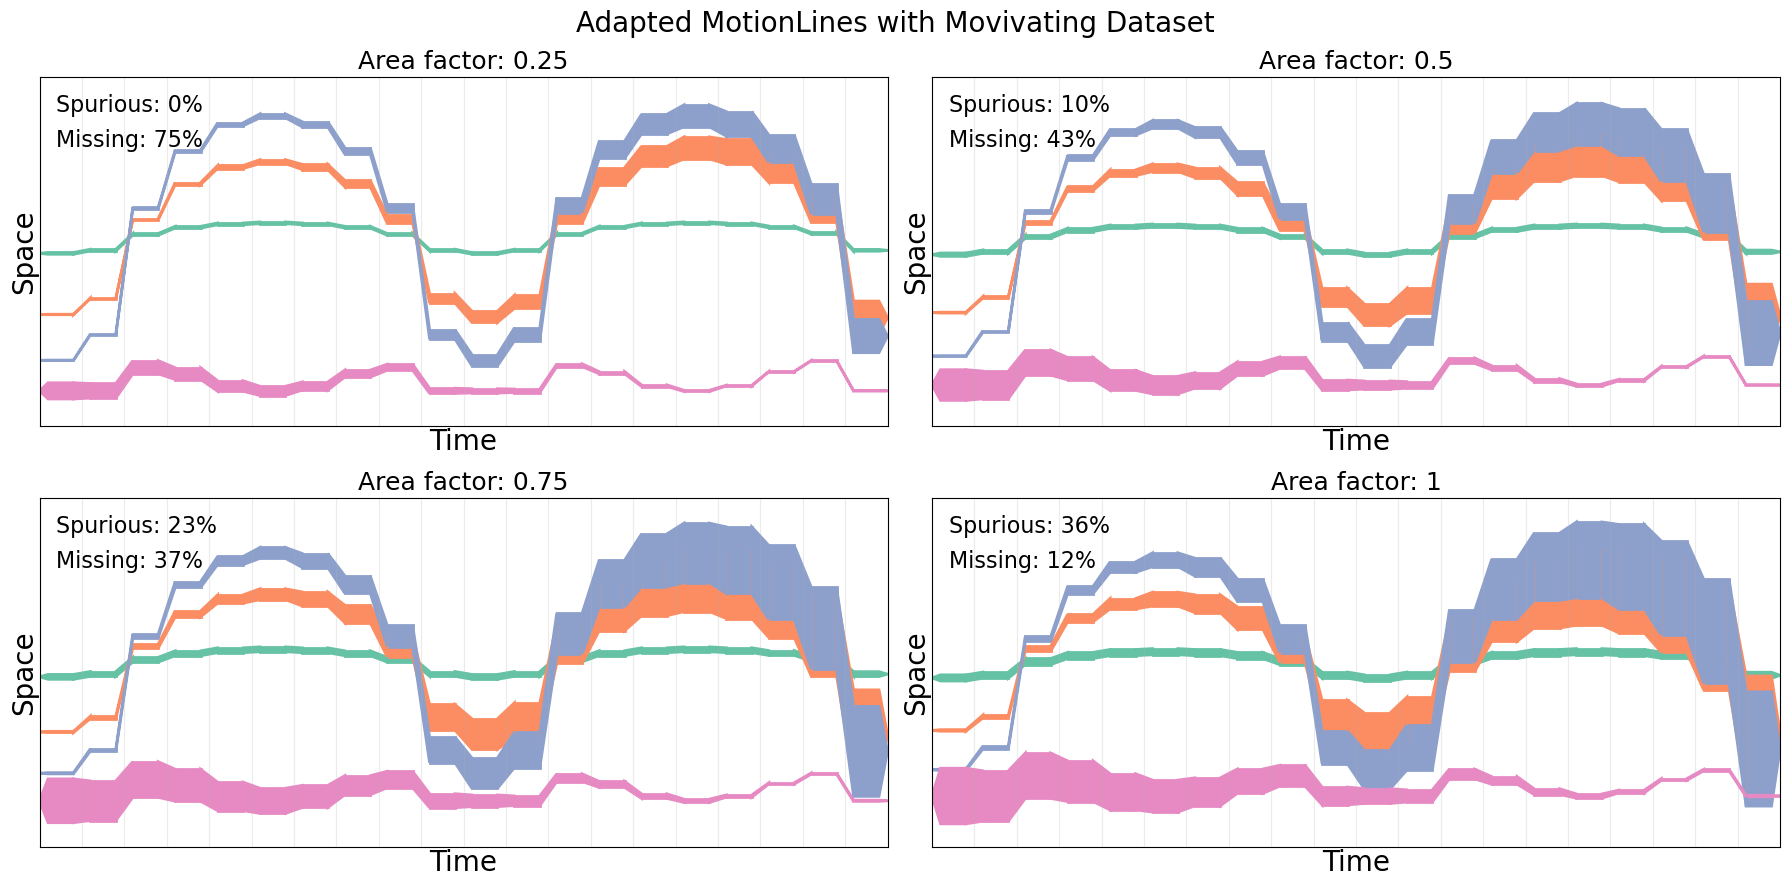

In [10]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 9))
axs = axs.flat 

for i, factor in enumerate(factors):
    result = MotionLines(
        motivating_df,
        colormap_name = "Set2",
        color_column_name = "object", 
        proportional_height = True,
        height_method = f"area_max_{factor}",
        ax = axs[i],
        plot_metrics = True
    )
    axs[i].set_title(f"Area factor: {factor}", fontsize = 18)

plt.suptitle("Adapted MotionLines with Movivating Dataset", fontsize = 20)
plt.tight_layout()
plt.savefig("plots/varying_width_motivating.svg", format = "svg", dpi = fig.dpi)
plt.show()

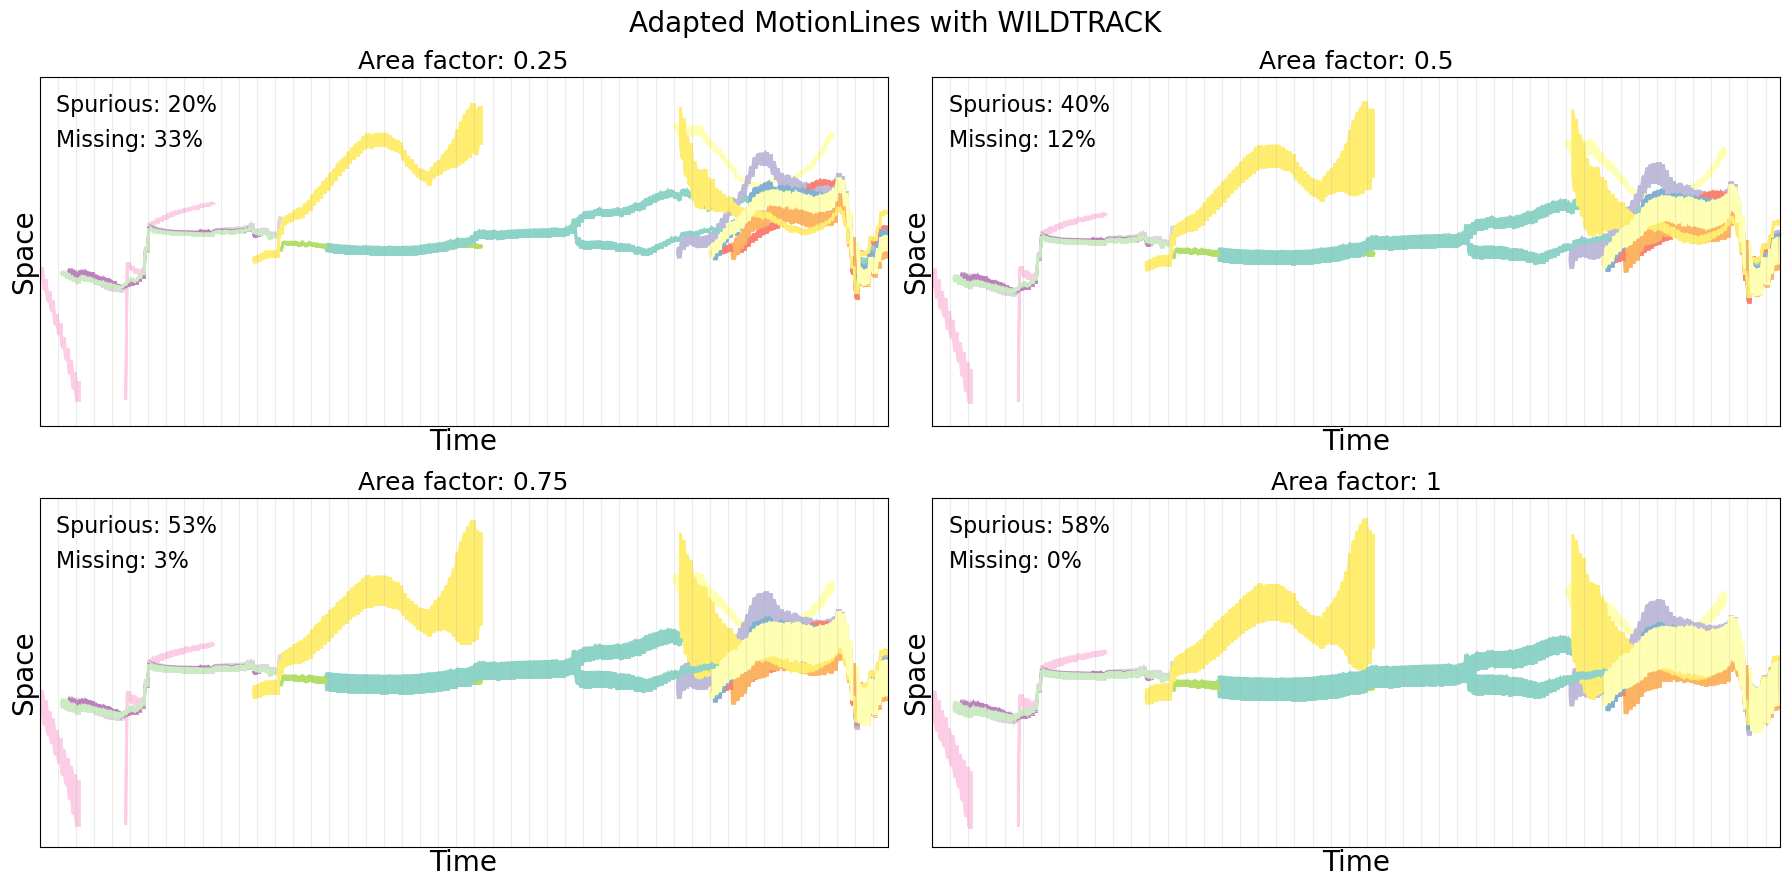

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 9))
axs = axs.flat 

for i, factor in enumerate(factors):
    result = MotionLines(
        wildtrack_df,
        colormap_name = "Set3",
        color_column_name = "object", 
        proportional_height = True,
        height_method = f"area_max_{factor}",
        ax = axs[i],
        plot_metrics = True
    )
    axs[i].set_title(f"Area factor: {factor}", fontsize = 18)

plt.suptitle("Adapted MotionLines with WILDTRACK", fontsize = 20)
plt.tight_layout()
plt.savefig("plots/varying_width_wildtrack.svg", format = "svg", dpi = fig.dpi)
plt.show()

## MoReVis Motivating Dataset

In [13]:
motivating_df = load_dataset("motivating")

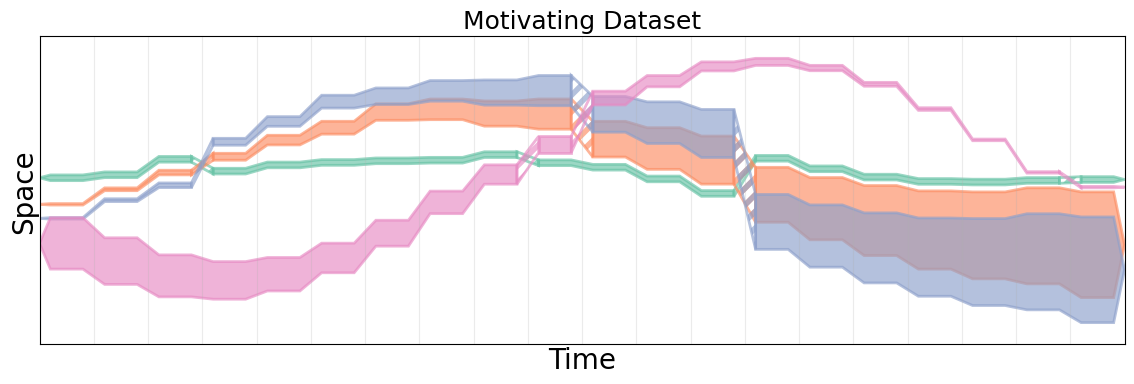

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14, 4))

plt.rcParams['hatch.linewidth'] = 4
result = MoReVis(
    motivating_df,
    colormap_name = "Set2",
    plot = False
)
result = concat_connections(result, False)
result["alpha"] = 0.65
plot_summary(result, ax = ax)
ax.set_title("Motivating Dataset", fontsize = 18)
#mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

plt.savefig("plots/morevis_motivating_dataset.pdf", format = "pdf", dpi = fig.dpi)
plt.show()